# Concepts & Visualizations

This notebook explains concepts and visualizes how different methods work.

1. **Feature Extraction Visualization** - See what different features capture
2. **Classifier Mechanisms** - Understand how classifiers work
3. **PCA Visualization** - Understand dimensionality reduction


In [17]:
# Imports
import cv2
import numpy as np
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2hsv
from skimage.measure import regionprops
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [18]:
# Prerequisite: Dataset Loading and Function Definitions
# (Copied from expert_level.ipynb for standalone execution)

def load_dataset():
    """Load dataset from disk."""
    # Get project root (go up from expert/ folder)
    current_dir = os.getcwd()
    if 'expert' in current_dir:
        project_root = os.path.dirname(current_dir)
    else:
        project_root = current_dir
    
    dataset_path = os.path.join(project_root, "datasets", "dataset1") + os.sep
    
    X = []
    y = []
    image_files = glob.glob(dataset_path + '*.png', recursive=True)
    
    for i in image_files:
        filename = os.path.basename(i)
        class_id = filename[:3]
        y.append(class_id)
        
        img = cv2.imread(i)
        if img is not None:
            X.append(img)
    
    return X, y

# Preprocessing Functions
def preprocessing_simple(X):
    """Simple: Resize + Grayscale"""
    X_processed = []
    for x in X:
        temp_x = cv2.resize(x, (48, 48))
        temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
        X_processed.append(temp_x)
    return X_processed

def preprocessing_blur(X):
    """Blur: Resize + Grayscale + Gaussian Blur"""
    X_processed = []
    for x in X:
        temp_x = cv2.resize(x, (48, 48))
        temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
        temp_x = cv2.GaussianBlur(temp_x, (3, 3), 0)
        X_processed.append(temp_x)
    return X_processed

def preprocessing_histogram_eq(X):
    """Histogram Equalization: Equalize each channel + Resize + Grayscale"""
    X_processed = []
    for x in X:
        b, g, r = cv2.split(x)
        bH = cv2.equalizeHist(b)
        gH = cv2.equalizeHist(g)
        rH = cv2.equalizeHist(r)
        result = cv2.merge((bH, gH, rH))
        result = cv2.resize(result, (48, 48))
        result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        X_processed.append(result)
    return X_processed

def preprocessing_advanced(X):
    """Advanced: Resize + Grayscale + Blur + Histogram Equalization + Normalization"""
    X_processed = []
    for x in X:
        temp_x = cv2.resize(x, (48, 48))
        temp_x = cv2.cvtColor(temp_x, cv2.COLOR_BGR2GRAY)
        temp_x = cv2.GaussianBlur(temp_x, (3, 3), 0)
        temp_x = cv2.equalizeHist(temp_x)
        temp_x = temp_x.astype(np.float32) / 255.0
        X_processed.append(temp_x)
    return X_processed

# Feature Extraction Functions
def feature_HOG(X_processed):
    """HOG: Histogram of Oriented Gradients"""
    X_features = []
    for x in X_processed:
        x_feature = hog(x, orientations=8, pixels_per_cell=(10, 10),
                        cells_per_block=(1, 1), visualize=False)
        X_features.append(x_feature)
    return np.array(X_features)

def feature_LBP(X_processed):
    """LBP: Local Binary Pattern"""
    X_features = []
    radius = 3
    n_points = 8 * radius
    for x in X_processed:
        x_feature = local_binary_pattern(x, n_points, radius)
        x_feature = x_feature.reshape(-1)
        X_features.append(x_feature)
    return np.array(X_features)

def feature_pyramid(X_processed):
    """Feature Pyramid: Multi-scale Laplacian pyramid"""
    num_layers = 3
    X_features = []
    for x in X_processed:
        gaussian_pyr = [x]
        image = x
        for i in range(1, num_layers):
            image = cv2.pyrDown(image)
            gaussian_pyr.append(image)
        
        laplacian_pyr = [gaussian_pyr[num_layers - 1]]
        for i in range(num_layers - 1, 0, -1):
            expanded = cv2.pyrUp(gaussian_pyr[i])
            laplacian = cv2.subtract(gaussian_pyr[i - 1], expanded)
            laplacian_pyr.append(laplacian)
        
        flattened_arrays = [arr.flatten() for arr in laplacian_pyr]
        x_feature = np.concatenate(flattened_arrays)
        X_features.append(x_feature)
    return np.array(X_features)

def feature_FFT(X_processed):
    """FFT: Frequency domain magnitude spectrum"""
    X_features = []
    for x in X_processed:
        f = np.fft.fft2(x)
        f_shift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
        magnitude_spectrum = magnitude_spectrum.reshape(-1)
        X_features.append(magnitude_spectrum)
    return np.array(X_features)

def feature_HuMoments(X_processed):
    """Hu Moments: 7 invariant shape moments"""
    X_features = []
    for x in X_processed:
        ret, binary = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            hu_moments = np.zeros(7)
        else:
            moments = cv2.moments(contours[0])
            hu_moments = cv2.HuMoments(moments).reshape(-1)
        X_features.append(hu_moments)
    return np.array(X_features)

def feature_multi(X, X_processed):
    """Multi-feature: HOG + Color (HSV) + Shape features"""
    X_features = []
    for x, x_processed in zip(X, X_processed):
        # HOG
        hog_feature = hog(x_processed, orientations=8, pixels_per_cell=(10, 10),
                          cells_per_block=(1, 1), visualize=False)
        
        # Color features (HSV)
        hsv_image = rgb2hsv(x)
        hue_hist = np.histogram(hsv_image[:, :, 0], bins=8, range=(0, 1))[0]
        sat_hist = np.histogram(hsv_image[:, :, 1], bins=8, range=(0, 1))[0]
        val_hist = np.histogram(hsv_image[:, :, 2], bins=8, range=(0, 1))[0]
        
        # Shape features
        label_img = np.uint8(x_processed > 0)
        props = regionprops(label_img)[0]
        shape_features = [props.area, props.perimeter, props.eccentricity]
        
        # Combine
        x_features = np.concatenate((hog_feature, hue_hist, sat_hist, val_hist, shape_features))
        X_features.append(x_features)
    return np.array(X_features)

# Load dataset
print("Loading dataset...")
X, y = load_dataset()
print(f"✓ Loaded {len(X)} images")
print(f"✓ {len(set(y))} unique classes")
print("✓ All prerequisite functions defined and dataset loaded!")


Loading dataset...
✓ Loaded 5998 images
✓ 58 unique classes
✓ All prerequisite functions defined and dataset loaded!


### Understanding Feature Extraction Methods

**What is Feature Extraction?**
Feature extraction converts raw images into numerical vectors (features) that capture important visual characteristics. Instead of using all pixel values directly, we extract meaningful patterns that help distinguish different traffic signs.

**Why do we need it?**
- Raw images are too high-dimensional (48×48 = 2,304 pixels)
- Most pixels don't contain useful information
- Features capture semantic meaning (edges, textures, shapes, colors)
- Makes classification faster and more accurate

---

### 1. **HOG (Histogram of Oriented Gradients)**

**Mathematical Explanation:**

For an image $I(x,y)$, HOG computes gradients:

$$\nabla_x I = \frac{\partial I}{\partial x}, \quad \nabla_y I = \frac{\partial I}{\partial y}$$

Gradient magnitude and orientation:

$$m(x,y) = \sqrt{\nabla_x I^2 + \nabla_y I^2}$$

$$\theta(x,y) = \arctan\left(\frac{\nabla_y I}{\nabla_x I}\right)$$

The histogram for each cell $C$ with $N$ pixels:

$$H_C[k] = \sum_{(x,y) \in C} m(x,y) \cdot w(\theta(x,y), k)$$

where $w(\theta, k)$ is the weight for orientation bin $k$ (typically 8 bins: $k \in \{0, 1, \ldots, 7\}$).

**What it captures:** Edge directions and shapes
- Divides image into small cells (e.g., 10×10 pixels)
- Calculates gradient direction in each cell
- Creates histogram of gradient orientations
- **Why useful:** Traffic signs have strong edges and distinct shapes
- **Output:** 128-dimensional vector (for 8 orientations × 16 cells)

**Example:** A stop sign's octagonal edges create specific gradient patterns

---

### 2. **LBP (Local Binary Pattern)**

**Mathematical Explanation:**

For a pixel $p_c$ with neighbors $p_i$ at radius $R$:

$$LBP_{P,R} = \sum_{i=0}^{P-1} s(p_i - p_c) \cdot 2^i$$

where $s(x) = \begin{cases} 1 & \text{if } x \geq 0 \\ 0 & \text{if } x < 0 \end{cases}$ is the sign function.

The histogram of LBP codes captures texture:

$$H[t] = \sum_{(x,y)} \delta(LBP_{P,R}(x,y) = t)$$

**What it captures:** Texture patterns
- Compares each pixel with its neighbors
- Creates binary code based on intensity comparisons
- Captures local texture variations
- **Why useful:** Different signs have different surface textures (smooth vs. textured)
- **Output:** 2,304-dimensional vector (one value per pixel)

**Example:** A speed limit sign's smooth surface vs. a warning sign's textured surface

---

### 3. **Feature Pyramid**

**Mathematical Explanation:**

Gaussian pyramid levels:

$$G_0 = I, \quad G_l = \text{Downsample}(G_{l-1} * g_\sigma)$$

Laplacian pyramid (difference between levels):

$$L_l = G_l - \text{Upsample}(G_{l+1})$$

where $g_\sigma$ is a Gaussian kernel with standard deviation $\sigma$.

**What it captures:** Multi-scale information
- Creates image pyramid at different resolutions
- Uses Laplacian pyramid (difference between scales)
- Captures both fine details and coarse structures
- **Why useful:** Signs appear at different scales in real images
- **Output:** 3,024-dimensional vector (combining all pyramid levels)

**Example:** Captures both the overall shape (coarse) and fine details (fine) of a sign

---

### 4. **FFT (Fast Fourier Transform)**

**Mathematical Explanation:**

2D Discrete Fourier Transform:

$$F(u,v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} I(x,y) \cdot e^{-j2\pi(ux/M + vy/N)}$$

Magnitude spectrum:

$$|F(u,v)| = \sqrt{\text{Re}(F(u,v))^2 + \text{Im}(F(u,v))^2}$$

Log magnitude (for visualization):

$$M(u,v) = \log(1 + |F(u,v)|)$$

**What it captures:** Frequency domain patterns
- Converts image from spatial domain to frequency domain
- Shows which spatial frequencies are present
- Low frequencies = smooth regions, High frequencies = edges/details
- **Why useful:** Different signs have different frequency signatures
- **Output:** 2,304-dimensional vector (magnitude spectrum)

**Example:** Circular signs have different frequency patterns than triangular signs

---

### 5. **Hu Moments**

**Mathematical Explanation:**

Central moments:

$$\mu_{pq} = \sum_{x} \sum_{y} (x - \bar{x})^p (y - \bar{y})^q I(x,y)$$

Normalized moments:

$$\eta_{pq} = \frac{\mu_{pq}}{\mu_{00}^{\gamma}}, \quad \gamma = \frac{p+q}{2} + 1$$

The 7 Hu invariant moments:

$$\begin{align}
\phi_1 &= \eta_{20} + \eta_{02} \\
\phi_2 &= (\eta_{20} - \eta_{02})^2 + 4\eta_{11}^2 \\
\phi_3 &= (\eta_{30} - 3\eta_{12})^2 + (3\eta_{21} - \eta_{03})^2 \\
\phi_4 &= (\eta_{30} + \eta_{12})^2 + (\eta_{21} + \eta_{03})^2 \\
\phi_5 &= (\eta_{30} - 3\eta_{12})(\eta_{30} + \eta_{12})[(\eta_{30} + \eta_{12})^2 - 3(\eta_{21} + \eta_{03})^2] \\
&\quad + (3\eta_{21} - \eta_{03})(\eta_{21} + \eta_{03})[3(\eta_{30} + \eta_{12})^2 - (\eta_{21} + \eta_{03})^2] \\
\phi_6 &= (\eta_{20} - \eta_{02})[(\eta_{30} + \eta_{12})^2 - (\eta_{21} + \eta_{03})^2] \\
&\quad + 4\eta_{11}(\eta_{30} + \eta_{12})(\eta_{21} + \eta_{03}) \\
\phi_7 &= (3\eta_{21} - \eta_{03})(\eta_{30} + \eta_{12})[(\eta_{30} + \eta_{12})^2 - 3(\eta_{21} + \eta_{03})^2] \\
&\quad - (\eta_{30} - 3\eta_{12})(\eta_{21} + \eta_{03})[3(\eta_{30} + \eta_{12})^2 - (\eta_{21} + \eta_{03})^2]
\end{align}$$

**What it captures:** Shape-invariant geometric properties
- Calculates 7 invariant moments from binary image
- Invariant to translation, rotation, and scale
- Describes overall shape characteristics
- **Why useful:** Sign shapes are distinctive (circle, triangle, octagon, etc.)
- **Output:** 7-dimensional vector (very compact!)

**Example:** A circle has different moment values than a triangle, regardless of size/rotation

---

### 6. **Multi-feature**

**Mathematical Explanation:**

Feature concatenation:

$$\mathbf{f}_{\text{multi}} = [\mathbf{f}_{\text{HOG}}, \mathbf{f}_{\text{HSV}}, \mathbf{f}_{\text{shape}}]$$

where:
- $\mathbf{f}_{\text{HOG}} \in \mathbb{R}^{128}$: HOG features
- $\mathbf{f}_{\text{HSV}} = [H_{\text{hist}}, S_{\text{hist}}, V_{\text{hist}}] \in \mathbb{R}^{24}$: HSV histograms
- $\mathbf{f}_{\text{shape}} = [A, P, e] \in \mathbb{R}^{3}$: Area, Perimeter, Eccentricity

**What it captures:** Combines multiple feature types
- **HOG:** Shape and edges (128 dims)
- **Color (HSV):** Hue, Saturation, Value histograms (24 dims)
- **Shape features:** Area, perimeter, eccentricity (3 dims)
- **Why useful:** Captures complementary information
- **Output:** 155-dimensional vector

**Example:** Combines shape (HOG), color (red stop sign vs. yellow warning), and geometry

---

### What is Feature Distribution?

**Feature distribution** shows how feature values are spread across all images in the dataset.

**Why it matters:**
1. **Scale differences:** Different methods produce values in different ranges
   - HOG: 0-1 (normalized)
   - LBP: 0-16 million (raw pixel comparisons)
   - FFT: 0-262 (log magnitude)

2. **Normalization needs:** Some classifiers need normalized features
   - SVM works better with normalized features
   - Random Forest is more robust to scale differences

3. **Information content:** Distribution shape tells us:
   - **Normal distribution:** Features are well-behaved
   - **Skewed distribution:** May need log transformation
   - **Bimodal distribution:** Features separate classes well

4. **Dimensionality:** Number of dimensions affects:
   - Training time (more dims = slower)
   - Overfitting risk (curse of dimensionality)
   - Memory requirements

**In the visualization above:**
- Histograms show the distribution of all feature values across 100 sample images
- Different methods have different value ranges and distributions
- This helps choose preprocessing (normalization, scaling) and understand which features are most informative


## Feature Extraction Visualization

Visualizing what different feature extraction methods capture from images.


Visualizing all feature extraction methods on sample images...



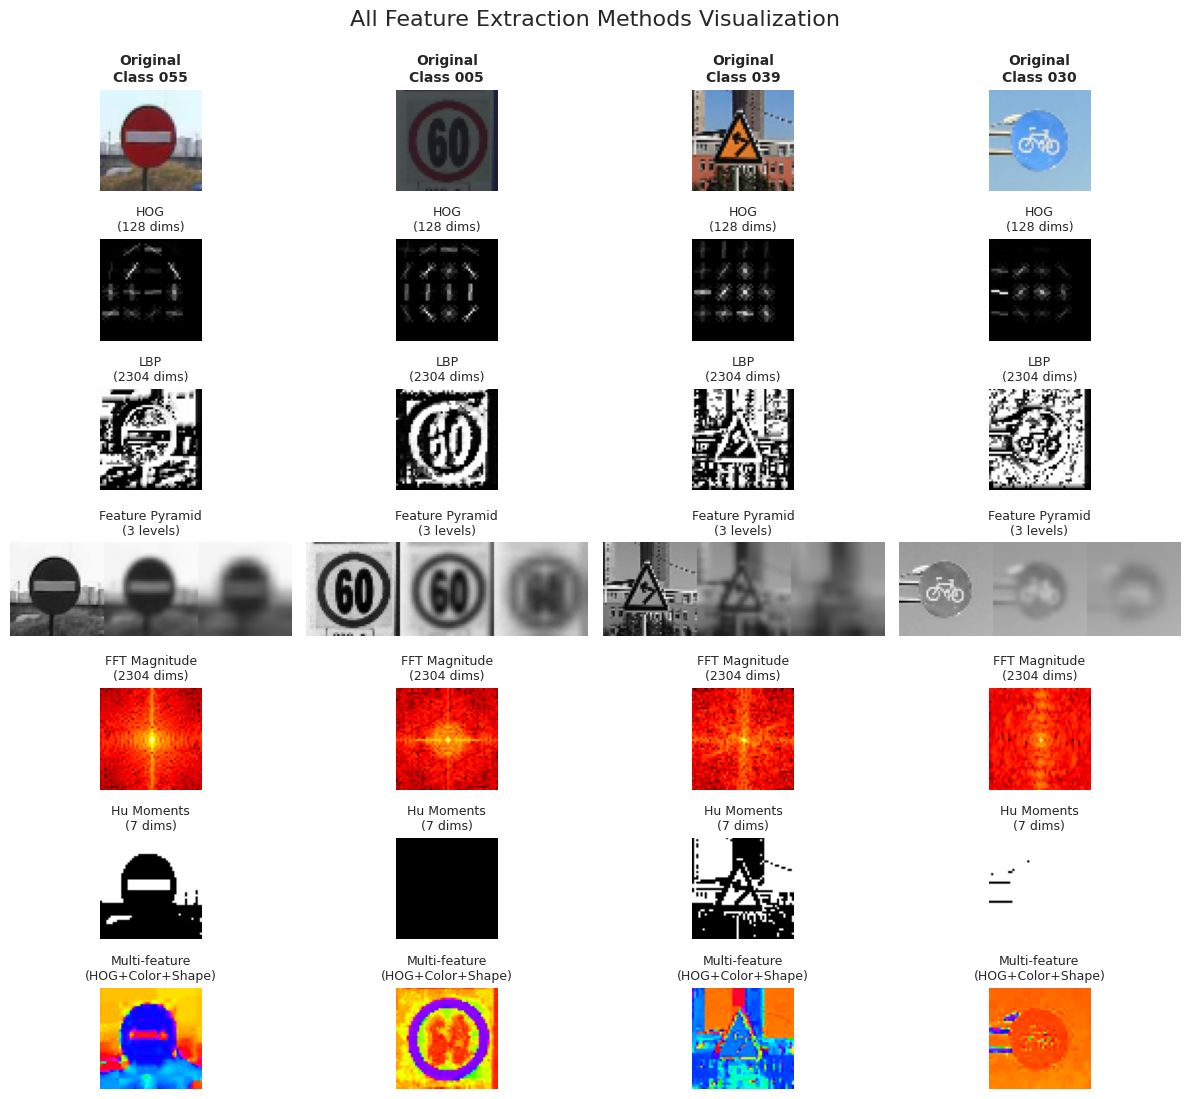

✓ HOG: Captures gradient orientations (edges/shapes)
✓ LBP: Captures texture patterns
✓ Feature Pyramid: Multi-scale representation
✓ FFT: Frequency domain patterns
✓ Hu Moments: Shape-invariant moments (from binary image)
✓ Multi-feature: Combines HOG + Color (HSV) + Shape features


In [19]:
# Visualize ALL Feature Extraction Methods
print("Visualizing all feature extraction methods on sample images...\n")

# Get a few sample images from different classes
sample_indices = [0, 500, 1000, 2000]  # Different classes
n_samples = len([i for i in sample_indices if i < len(X)])
n_features = 6  # HOG, LBP, Pyramid, FFT, Hu Moments, Multi-feature

fig, axes = plt.subplots(n_features + 1, n_samples, figsize=(12, 11))
fig.suptitle('All Feature Extraction Methods Visualization', fontsize=16, y=0.995)

for idx, sample_idx in enumerate(sample_indices):
    if sample_idx >= len(X):
        continue
    
    # Original image
    img = X[sample_idx]
    img_resized = cv2.resize(img, (48, 48))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    # Row 0: Original images
    axes[0, idx].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axes[0, idx].set_title(f'Original\nClass {y[sample_idx]}', fontsize=10, fontweight='bold')
    axes[0, idx].axis('off')
    
    # Row 1: HOG visualization
    hog_feat, hog_image = hog(img_gray, orientations=8, pixels_per_cell=(10, 10),
                              cells_per_block=(1, 1), visualize=True)
    axes[1, idx].imshow(hog_image, cmap='gray')
    axes[1, idx].set_title(f'HOG\n({len(hog_feat)} dims)', fontsize=9)
    axes[1, idx].axis('off')
    
    # Row 2: LBP visualization
    radius = 3
    n_points = 8 * radius
    lbp = local_binary_pattern(img_gray, n_points, radius)
    axes[2, idx].imshow(lbp, cmap='gray')
    axes[2, idx].set_title(f'LBP\n({lbp.size} dims)', fontsize=9)
    axes[2, idx].axis('off')
    
    # Row 3: Feature Pyramid visualization
    num_layers = 3
    gaussian_pyr = [img_gray]
    image = img_gray
    for i in range(1, num_layers):
        image = cv2.pyrDown(image)
        gaussian_pyr.append(image)
    
    # Show all pyramid levels side by side
    pyramid_display = np.hstack([cv2.resize(level, (48, 48)) for level in gaussian_pyr])
    axes[3, idx].imshow(pyramid_display, cmap='gray')
    axes[3, idx].set_title(f'Feature Pyramid\n({num_layers} levels)', fontsize=9)
    axes[3, idx].axis('off')
    
    # Row 4: FFT visualization
    f = np.fft.fft2(img_gray)
    f_shift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
    axes[4, idx].imshow(magnitude_spectrum, cmap='hot')
    axes[4, idx].set_title(f'FFT Magnitude\n({magnitude_spectrum.size} dims)', fontsize=9)
    axes[4, idx].axis('off')
    
    # Row 5: Hu Moments visualization (show binary image used)
    ret, binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    axes[5, idx].imshow(binary, cmap='gray')
    axes[5, idx].set_title(f'Hu Moments\n(7 dims)', fontsize=9)
    axes[5, idx].axis('off')
    
    # Row 6: Multi-feature visualization (show combined representation)
    # Create a visual representation showing different feature types
    hsv_image = rgb2hsv(img_resized)
    hue_channel = hsv_image[:, :, 0]
    axes[6, idx].imshow(hue_channel, cmap='hsv')
    axes[6, idx].set_title(f'Multi-feature\n(HOG+Color+Shape)', fontsize=9)
    axes[6, idx].axis('off')

plt.tight_layout()
plt.show()

print("✓ HOG: Captures gradient orientations (edges/shapes)")
print("✓ LBP: Captures texture patterns")
print("✓ Feature Pyramid: Multi-scale representation")
print("✓ FFT: Frequency domain patterns")
print("✓ Hu Moments: Shape-invariant moments (from binary image)")
print("✓ Multi-feature: Combines HOG + Color (HSV) + Shape features")


Comparing feature distributions across all extraction methods...



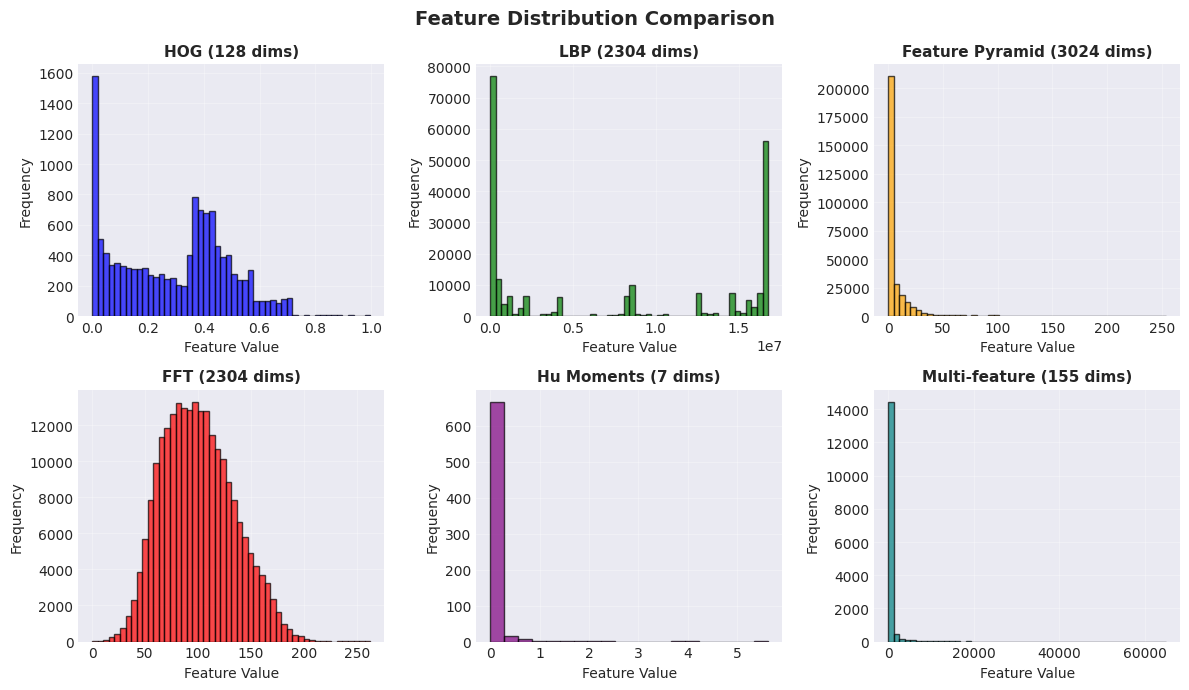

✓ HOG: 128 dims, range [0.00, 1.00]
✓ LBP: 2304 dims, range [0.00, 16777215.00]
✓ Pyramid: 3024 dims, range [0.00, 254.00]
✓ FFT: 2304 dims, range [0.00, 262.80]
✓ Hu Moments: 7 dims, range [-0.00, 5.63]
✓ Multi-feature: 155 dims, range [0.00, 65022.00]


In [20]:
# Compare Feature Distributions for ALL Methods
print("Comparing feature distributions across all extraction methods...\n")

# Preprocess sample
X_sample = preprocessing_blur(X[:100])  # Use 100 samples for speed

# Extract all features
hog_features = feature_HOG(X_sample)
lbp_features = feature_LBP(X_sample)
pyramid_features = feature_pyramid(X_sample)
fft_features = feature_FFT(X_sample)
hu_features = feature_HuMoments(X_sample)
multi_features = feature_multi(X[:100], preprocessing_advanced(X[:100]))

# Plot feature distributions
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('Feature Distribution Comparison', fontsize=14, fontweight='bold')

# HOG
axes[0, 0].hist(hog_features.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title(f'HOG ({hog_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Feature Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# LBP
axes[0, 1].hist(lbp_features.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title(f'LBP ({lbp_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Feature Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Feature Pyramid
axes[0, 2].hist(pyramid_features.flatten(), bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0, 2].set_title(f'Feature Pyramid ({pyramid_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[0, 2].set_xlabel('Feature Value')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# FFT
axes[1, 0].hist(fft_features.flatten(), bins=50, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title(f'FFT ({fft_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Feature Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Hu Moments
axes[1, 1].hist(hu_features.flatten(), bins=20, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title(f'Hu Moments ({hu_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Feature Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# Multi-feature
axes[1, 2].hist(multi_features.flatten(), bins=50, alpha=0.7, color='teal', edgecolor='black')
axes[1, 2].set_title(f'Multi-feature ({multi_features.shape[1]} dims)', fontsize=11, fontweight='bold')
axes[1, 2].set_xlabel('Feature Value')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ HOG: {hog_features.shape[1]} dims, range [{hog_features.min():.2f}, {hog_features.max():.2f}]")
print(f"✓ LBP: {lbp_features.shape[1]} dims, range [{lbp_features.min():.2f}, {lbp_features.max():.2f}]")
print(f"✓ Pyramid: {pyramid_features.shape[1]} dims, range [{pyramid_features.min():.2f}, {pyramid_features.max():.2f}]")
print(f"✓ FFT: {fft_features.shape[1]} dims, range [{fft_features.min():.2f}, {fft_features.max():.2f}]")
print(f"✓ Hu Moments: {hu_features.shape[1]} dims, range [{hu_features.min():.2f}, {hu_features.max():.2f}]")
print(f"✓ Multi-feature: {multi_features.shape[1]} dims, range [{multi_features.min():.2f}, {multi_features.max():.2f}]")


## Classifier Mechanisms Explained

### 1. SVM (Support Vector Machine)

**Mathematical Explanation:**

SVM finds the optimal hyperplane $\mathbf{w}^T \mathbf{x} + b = 0$ that maximizes the margin:

$$\min_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2 \quad \text{subject to} \quad y_i(\mathbf{w}^T \mathbf{x}_i + b) \geq 1, \forall i$$

Using Lagrange multipliers, the dual form becomes:

$$\max_{\alpha} \sum_{i=1}^{n} \alpha_i - \frac{1}{2}\sum_{i,j=1}^{n} \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j)$$

subject to $\sum_{i=1}^{n} \alpha_i y_i = 0$ and $0 \leq \alpha_i \leq C$.

The decision function:

$$f(\mathbf{x}) = \sum_{i \in SV} \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b$$

where $K(\mathbf{x}_i, \mathbf{x}_j)$ is the kernel function (e.g., RBF: $K(\mathbf{x}_i, \mathbf{x}_j) = \exp(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2)$).

**How it works**: Finds optimal hyperplane that separates classes with maximum margin.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/2a/Svm_max_sep_hyperplane_with_margin.png" width="300" alt="SVM Mechanism">

**Key points**:
- Hyperplane = decision boundary
- Support vectors = critical samples on margin ($\alpha_i > 0$)
- Kernel trick handles non-linear boundaries
- Pros: Good for high-dim data, memory efficient
- Cons: Slow for large datasets, needs feature scaling


Visualizing SVM decision boundary on 2D feature projection...



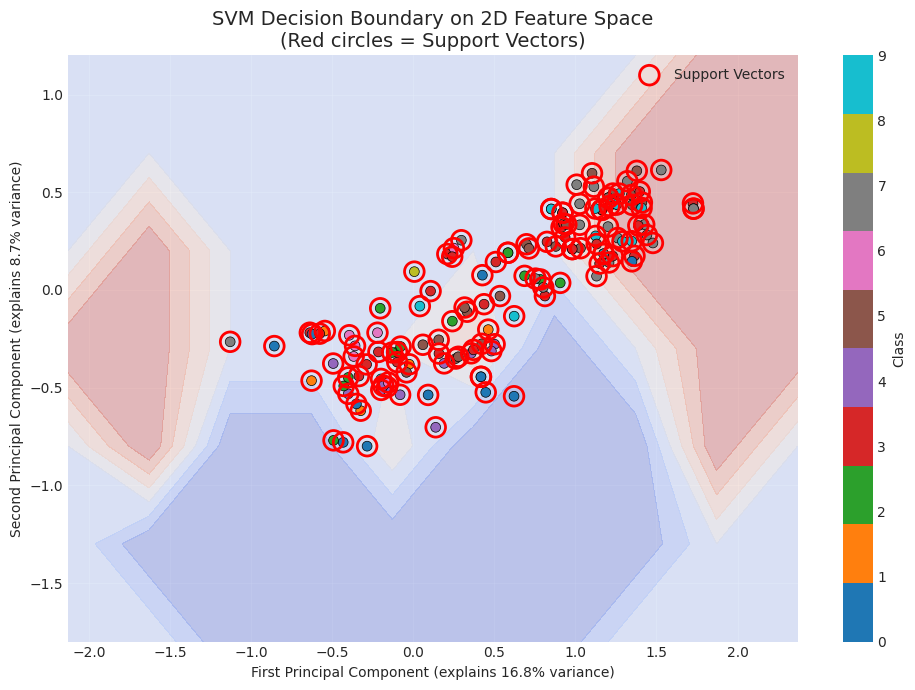

✓ Total samples: 136
✓ Support vectors: 136 (100.0% of data)
✓ Support vectors are the critical samples that define the decision boundary


In [21]:
# Visualize SVM Decision Boundary (2D projection)
print("Visualizing SVM decision boundary on 2D feature projection...\n")

# Use PCA to reduce to 2D for visualization
X_processed_viz = preprocessing_blur(X[:500])  # Use subset for speed
X_features_viz = feature_HOG(X_processed_viz)
y_viz = y[:500]

# Reduce to 2D using PCA
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_features_viz)

# Get unique classes and assign colors
unique_classes = sorted(set(y_viz))[:10]  # Use first 10 classes
class_to_num = {cls: idx for idx, cls in enumerate(unique_classes)}
y_numeric = [class_to_num.get(cls, -1) for cls in y_viz]

# Filter to only classes we're visualizing
mask = np.array([cls in unique_classes for cls in y_viz])
X_2d_filtered = X_2d[mask]
y_numeric_filtered = np.array(y_numeric)[mask]

# Train SVM
svm_viz = SVC(kernel='rbf', C=1.0)
svm_viz.fit(X_2d_filtered, y_numeric_filtered)

# Create mesh for decision boundary
h = 0.5
x_min, x_max = X_2d_filtered[:, 0].min() - 1, X_2d_filtered[:, 0].max() + 1
y_min, y_max = X_2d_filtered[:, 1].min() - 1, X_2d_filtered[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = svm_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_2d_filtered[:, 0], X_2d_filtered[:, 1], 
                     c=y_numeric_filtered, cmap=plt.cm.tab10, 
                     edgecolors='black', linewidths=0.5, s=50)

# Highlight support vectors
plt.scatter(X_2d_filtered[svm_viz.support_][:, 0], 
           X_2d_filtered[svm_viz.support_][:, 1],
           s=200, facecolors='none', edgecolors='red', 
           linewidths=2, label='Support Vectors')

plt.xlabel(f'First Principal Component (explains {pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Second Principal Component (explains {pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('SVM Decision Boundary on 2D Feature Space\n(Red circles = Support Vectors)', fontsize=14)
plt.legend()
plt.colorbar(scatter, label='Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✓ Total samples: {len(X_2d_filtered)}")
print(f"✓ Support vectors: {len(svm_viz.support_)} ({len(svm_viz.support_)/len(X_2d_filtered)*100:.1f}% of data)")
print("✓ Support vectors are the critical samples that define the decision boundary")


## PCA Mechanism Visualization

**Mathematical Explanation:**

PCA finds principal components by solving the eigenvalue problem:

$$\mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i$$

where $\mathbf{C} = \frac{1}{n-1}\mathbf{X}^T\mathbf{X}$ is the covariance matrix, $\lambda_i$ are eigenvalues, and $\mathbf{v}_i$ are eigenvectors (principal components).

The projection onto $k$ principal components:

$$\mathbf{Y} = \mathbf{X} \mathbf{V}_k$$

where $\mathbf{V}_k = [\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_k]$ contains the top $k$ eigenvectors.

Variance explained by component $i$:

$$\text{Var}_i = \frac{\lambda_i}{\sum_{j=1}^{d} \lambda_j}$$

**How PCA works**: Finds directions (principal components) with maximum variance and projects data onto them.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg" width="300" alt="PCA Mechanism">

**Steps**:
1. Find principal components (directions of max variance)
2. Project data onto these components
3. Keep top N components (e.g., 100 out of 155)
4. Result: Lower dimensions, preserved information


Visualizing PCA dimensionality reduction...

Original feature dimension: 155
   10 components: 90.97% variance explained
   50 components: 100.00% variance explained
  100 components: 100.00% variance explained
  155 components: 100.00% variance explained


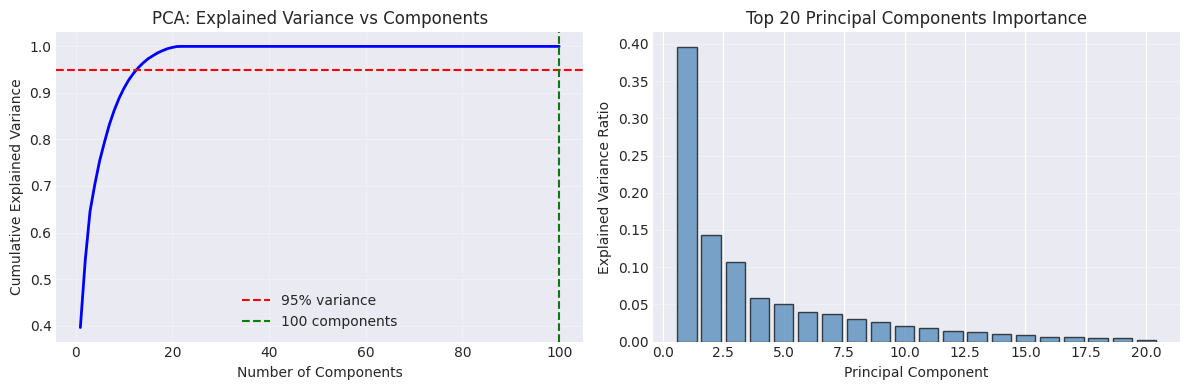


✓ First component explains 39.59% of variance
✓ Top 10 components explain 90.97% of variance
✓ Top 100 components explain 100.00% of variance
✓ PCA reduces dimensions while preserving most information


In [22]:
# Visualize PCA Effect
print("Visualizing PCA dimensionality reduction...\n")

# Get multi-features
X_processed_pca = preprocessing_advanced(X[:1000])
X_features_pca = feature_multi(X[:1000], X_processed_pca)

print(f"Original feature dimension: {X_features_pca.shape[1]}")

# Apply PCA with different components
n_components_list = [10, 50, 100, X_features_pca.shape[1]]
explained_variances = []

for n_comp in n_components_list:
    pca_temp = PCA(n_components=min(n_comp, X_features_pca.shape[1]))
    X_pca_temp = pca_temp.fit_transform(X_features_pca)
    explained_var = pca_temp.explained_variance_ratio_.sum()
    explained_variances.append(explained_var)
    print(f"  {n_comp:3d} components: {explained_var*100:.2f}% variance explained")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Explained variance ratio
pca_full = PCA()
pca_full.fit(X_features_pca)
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

axes[0].plot(range(1, min(101, len(cumsum_var)+1)), cumsum_var[:100], 'b-', linewidth=2)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[0].axvline(x=100, color='g', linestyle='--', label='100 components')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA: Explained Variance vs Components', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Component importance
axes[1].bar(range(1, 21), pca_full.explained_variance_ratio_[:20], 
           color='steelblue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('Top 20 Principal Components Importance', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ First component explains {pca_full.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"✓ Top 10 components explain {cumsum_var[9]*100:.2f}% of variance")
print(f"✓ Top 100 components explain {cumsum_var[99]*100:.2f}% of variance")
print("✓ PCA reduces dimensions while preserving most information")


Visualizing how PCA transforms the feature space...



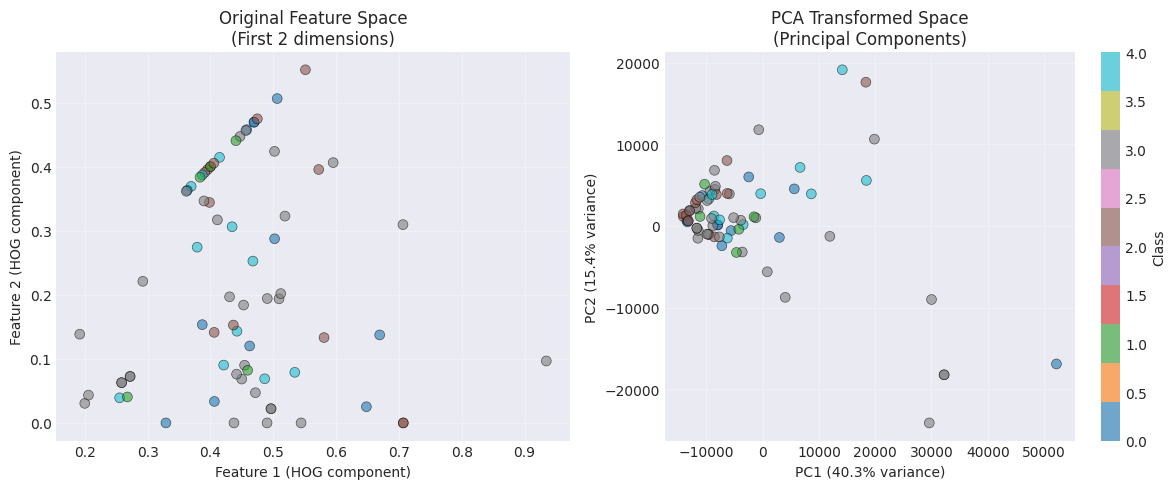

✓ PCA rotates data to align with directions of maximum variance
✓ Classes become more separated in PCA space
✓ This makes classification easier


In [23]:
# Visualize PCA Transformation Effect
print("Visualizing how PCA transforms the feature space...\n")

# Use subset for visualization
X_processed_pca2 = preprocessing_advanced(X[:500])
X_features_pca2 = feature_multi(X[:500], X_processed_pca2)
y_pca2 = y[:500]

# Apply PCA
pca_viz = PCA(n_components=2)
X_pca_2d = pca_viz.fit_transform(X_features_pca2)

# Get class labels for first 5 classes
unique_classes_viz = sorted(set(y_pca2))[:5]
class_colors = {cls: idx for idx, cls in enumerate(unique_classes_viz)}
y_colors = [class_colors.get(cls, -1) for cls in y_pca2]

# Filter
mask_viz = np.array([cls in unique_classes_viz for cls in y_pca2])
X_original_2d = X_features_pca2[mask_viz]
X_pca_2d_filtered = X_pca_2d[mask_viz]
y_colors_filtered = np.array(y_colors)[mask_viz]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original feature space (first 2 dimensions)
axes[0].scatter(X_original_2d[:, 0], X_original_2d[:, 1], 
               c=y_colors_filtered, cmap=plt.cm.tab10, 
               alpha=0.6, edgecolors='black', linewidths=0.5, s=50)
axes[0].set_xlabel('Feature 1 (HOG component)')
axes[0].set_ylabel('Feature 2 (HOG component)')
axes[0].set_title('Original Feature Space\n(First 2 dimensions)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# PCA transformed space
scatter = axes[1].scatter(X_pca_2d_filtered[:, 0], X_pca_2d_filtered[:, 1],
                         c=y_colors_filtered, cmap=plt.cm.tab10,
                         alpha=0.6, edgecolors='black', linewidths=0.5, s=50)
axes[1].set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[1].set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[1].set_title('PCA Transformed Space\n(Principal Components)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.colorbar(scatter, ax=axes[1], label='Class')
plt.tight_layout()
plt.show()

print("✓ PCA rotates data to align with directions of maximum variance")
print("✓ Classes become more separated in PCA space")
print("✓ This makes classification easier")


## 2. Random Forest

**Mathematical Explanation:**

Random Forest combines $B$ decision trees trained on bootstrap samples:

$$\hat{y} = \frac{1}{B}\sum_{b=1}^{B} T_b(\mathbf{x})$$

where $T_b$ is the $b$-th tree. For classification, majority voting:

$$\hat{y} = \arg\max_{c} \sum_{b=1}^{B} \mathbb{1}(T_b(\mathbf{x}) = c)$$

**How it works**: Ensemble of decision trees, majority vote wins.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4e/Random_forest_explain.png" width="300" alt="Random Forest">

**Key points**: Bootstrap sampling, feature randomness, voting. Pros: Handles overfitting, non-linear data. Cons: Less interpretable, can be slow.

---

### 3. kNN (k-Nearest Neighbors)

**Mathematical Explanation:**

For a query point $\mathbf{x}_q$, find $k$ nearest neighbors using distance metric:

$$d(\mathbf{x}_q, \mathbf{x}_i) = \|\mathbf{x}_q - \mathbf{x}_i\|_2 = \sqrt{\sum_{j=1}^{d} (x_{qj} - x_{ij})^2}$$

Classification by majority vote:

$$\hat{y} = \arg\max_{c} \sum_{i \in \mathcal{N}_k} \mathbb{1}(y_i = c)$$

where $\mathcal{N}_k$ is the set of $k$ nearest neighbors.

**How it works**: Classify by k nearest training examples (lazy learning).

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg" width="300" alt="kNN Mechanism">

**Key points**: Euclidean distance, k value matters. Pros: Simple, no training. Cons: Slow prediction, needs scaling.

---

### 4. Decision Tree

**Mathematical Explanation:**

Splits are chosen to maximize information gain (using entropy):

$$H(S) = -\sum_{c \in C} p(c) \log_2 p(c)$$

Information gain:

$$\text{IG}(S, A) = H(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} H(S_v)$$

Alternatively, using Gini impurity:

$$G(S) = 1 - \sum_{c \in C} p(c)^2$$

**How it works**: If-else rules, splits based on feature values.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/CART_tree_titanic_survivors.png" width="300" alt="Decision Tree">

**Key points**: Splits (entropy/Gini), nodes, pruning. Pros: Interpretable, handles non-linear. Cons: Overfitting, unstable.

---

### 5. Naive Bayes

**Mathematical Explanation:**

Bayes' theorem with independence assumption:

$$P(y|\mathbf{x}) = \frac{P(\mathbf{x}|y) P(y)}{P(\mathbf{x})} = \frac{P(y) \prod_{i=1}^{d} P(x_i|y)}{P(\mathbf{x})}$$

Classification decision:

$$\hat{y} = \arg\max_{y} P(y) \prod_{i=1}^{d} P(x_i|y)$$

For Gaussian Naive Bayes:

$$P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma_{yi}^2}} \exp\left(-\frac{(x_i - \mu_{yi})^2}{2\sigma_{yi}^2}\right)$$

**How it works**: Bayes theorem with independence assumption.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*J5MLEJwQqhW41wg6.png" width="300" alt="Naive Bayes">

**Key points**: P(class|features) = P(features|class) × P(class) / P(features). Pros: Fast, works with small data. Cons: Independence assumption rarely true.

---

### 6. MLP (Multi-Layer Perceptron)

**Mathematical Explanation:**

Forward propagation through layers:

$$\mathbf{z}^{(l)} = \mathbf{W}^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}$$

$$\mathbf{a}^{(l)} = \sigma(\mathbf{z}^{(l)})$$

where $\sigma$ is the activation function (e.g., ReLU: $\sigma(x) = \max(0, x)$, Sigmoid: $\sigma(x) = \frac{1}{1+e^{-x}}$).

Backpropagation updates weights using gradient descent:

$$\mathbf{W}^{(l)} \leftarrow \mathbf{W}^{(l)} - \alpha \frac{\partial L}{\partial \mathbf{W}^{(l)}}$$

where $L$ is the loss function (e.g., cross-entropy for classification).

**How it works**: Feedforward neural network with multiple layers.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/46/Colored_neural_network.svg" width="300" alt="MLP Architecture">

**Key points**: Input/hidden/output layers, activation functions, backpropagation. Pros: Learns complex patterns. Cons: Needs more data, requires tuning.


Visualizing how different classifiers separate classes...



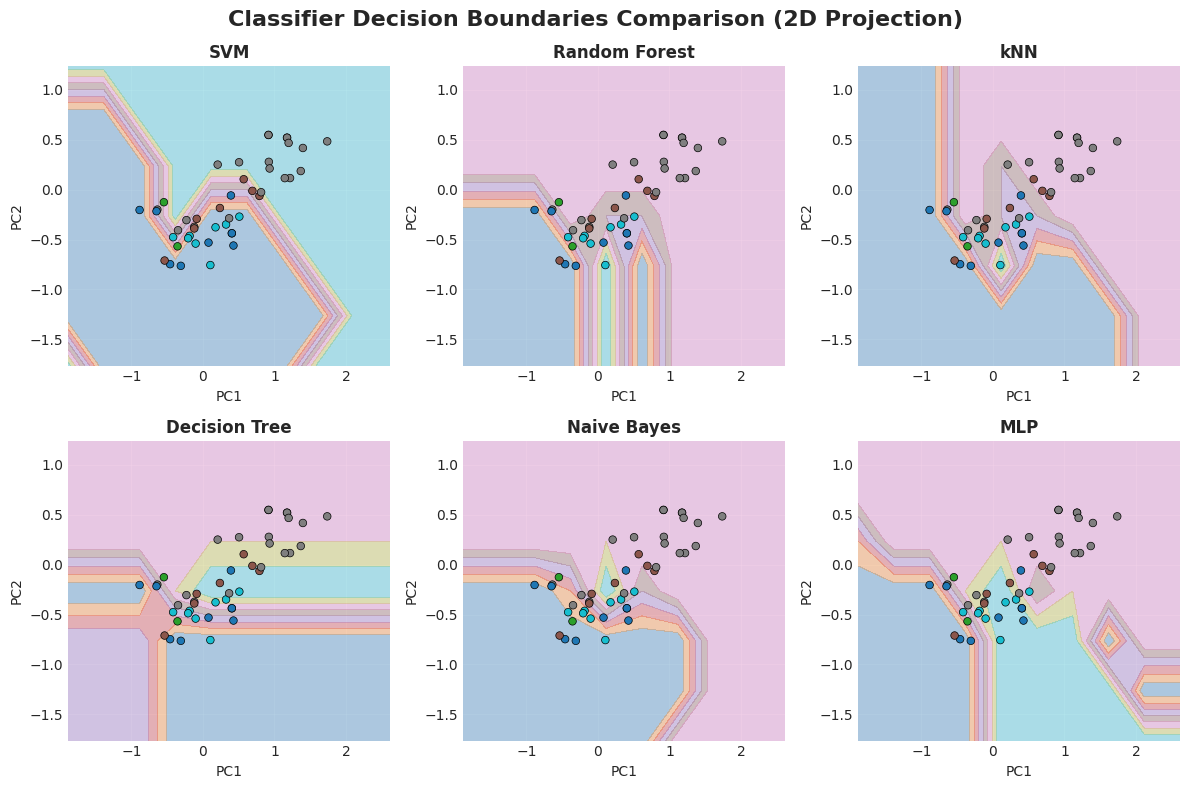

✓ Different classifiers create different decision boundaries
✓ SVM: Smooth boundaries with maximum margin
✓ Random Forest: Complex, piecewise boundaries
✓ kNN: Voronoi-like regions
✓ Decision Tree: Axis-aligned rectangular regions
✓ Naive Bayes: Elliptical regions (Gaussian assumption)
✓ MLP: Smooth, complex non-linear boundaries


In [24]:
# Visualize Classifier Decision Boundaries (2D projection)
print("Visualizing how different classifiers separate classes...\n")

# Use subset for speed
X_processed_clf = preprocessing_blur(X[:300])
X_features_clf = feature_HOG(X_processed_clf)
y_clf = y[:300]

# Reduce to 2D using PCA
pca_clf = PCA(n_components=2)
X_2d_clf = pca_clf.fit_transform(X_features_clf)

# Use first 5 classes for visualization
unique_classes_clf = sorted(set(y_clf))[:5]
class_to_num_clf = {cls: idx for idx, cls in enumerate(unique_classes_clf)}
y_numeric_clf = np.array([class_to_num_clf.get(cls, -1) for cls in y_clf])

mask_clf = np.array([cls in unique_classes_clf for cls in y_clf])
X_2d_clf_filtered = X_2d_clf[mask_clf]
y_numeric_clf_filtered = y_numeric_clf[mask_clf]

# Train classifiers
classifiers_viz = {
    'SVM': SVC(kernel='rbf', C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=5),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Naive Bayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
}

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Classifier Decision Boundaries Comparison (2D Projection)', fontsize=16, fontweight='bold')

for idx, (name, clf) in enumerate(classifiers_viz.items()):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # Train classifier
    clf.fit(X_2d_clf_filtered, y_numeric_clf_filtered)
    
    # Create mesh
    h = 0.5
    x_min, x_max = X_2d_clf_filtered[:, 0].min() - 1, X_2d_clf_filtered[:, 0].max() + 1
    y_min, y_max = X_2d_clf_filtered[:, 1].min() - 1, X_2d_clf_filtered[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    scatter = ax.scatter(X_2d_clf_filtered[:, 0], X_2d_clf_filtered[:, 1],
                        c=y_numeric_clf_filtered, cmap=plt.cm.tab10,
                        edgecolors='black', linewidths=0.5, s=30)
    
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Different classifiers create different decision boundaries")
print("✓ SVM: Smooth boundaries with maximum margin")
print("✓ Random Forest: Complex, piecewise boundaries")
print("✓ kNN: Voronoi-like regions")
print("✓ Decision Tree: Axis-aligned rectangular regions")
print("✓ Naive Bayes: Elliptical regions (Gaussian assumption)")
print("✓ MLP: Smooth, complex non-linear boundaries")
